### Imports

In [1]:
import h5py
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
data = h5py.File("data/CH_D3.jld2", "r")

### Config

In [2]:
input_size = output_size = 10_000
hidden_size = 5096
num_layers = 1
seq_length = 100
batch_size = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_index = 260

### Dataloading and Preping

In [3]:
X1_CH = torch.Tensor(np.array(data["X1"]))
X2_CH = torch.Tensor(np.array(data["X2"]))
X3_CH = torch.Tensor(np.array(data["X3"]))

dt_CH = 0.1

In [4]:
y1 = X1_CH[101:, :]
X1 = torch.stack([X1_CH[i:i+100, :] for i in range(1, 301)])

y1_train = y1[:train_index, :]
y1_test = y1[train_index:, :]

X1_train = X1[:train_index, :, :]
X1_test = X1[train_index:, :, :]

In [5]:
# Shapes:
# X: (300, 100, 10_000)
# y: (300, 10_000)

In [6]:
class X1Trajectories(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [7]:
train_set = X1Trajectories(X1_train, y1_train)
test_set = X1Trajectories(X1_test, y1_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Model architecture

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (Batch, Seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)
        self.c0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)

    def forward(self, x):
        out, _ = self.lstm(x, (self.h0, self.c0))
        out = f.tanh(self.fc(out[:,-1,:]))
        return out


In [9]:
model = PINN()
model.to(device)

PINN(
  (lstm): LSTM(10000, 5096, batch_first=True)
  (fc): Linear(in_features=5096, out_features=10000, bias=True)
)

### Training

In [10]:
loss_func = nn.MSELoss() # + PDE informed loss
lr = 1e-3
num_epochs = 4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    model.train(True)
    print(f"Starting epoch: {epoch + 1}")
    print(f"*******************************")
    running_loss = 0.0
    epoch_loss = 0.0

    for i, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        running_loss += loss
        epoch_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 5 == 0 and i > 0:
            avg_loss = running_loss / 5
            print(f"Batch {i}, Loss: {avg_loss : .3f}")
            running_loss = 0.0
    
    epoch_loss /= len(train_loader)
    print(f"Average Loss over epoch: {epoch_loss: .3f}")
    print(f"*******************************")

Epoch: 1
Batch 5, Loss:  0.261
Batch 10, Loss:  0.099
Batch 15, Loss:  0.111
Batch 20, Loss:  0.107
Batch 25, Loss:  0.115
Batch 30, Loss:  0.084
Batch 35, Loss:  0.086
Batch 40, Loss:  0.082
Batch 45, Loss:  0.094
Batch 50, Loss:  0.085
Epoch: 2
Batch 5, Loss:  0.113
Batch 10, Loss:  0.100
Batch 15, Loss:  0.098
Batch 20, Loss:  0.089
Batch 25, Loss:  0.075
Batch 30, Loss:  0.085
Batch 35, Loss:  0.084
Batch 40, Loss:  0.086
Batch 45, Loss:  0.071
Batch 50, Loss:  0.084
Epoch: 3
Batch 5, Loss:  0.085
Batch 10, Loss:  0.077
Batch 15, Loss:  0.089
Batch 20, Loss:  0.084
Batch 25, Loss:  0.075
Batch 30, Loss:  0.084
Batch 35, Loss:  0.073
Batch 40, Loss:  0.064
Batch 45, Loss:  0.081
Batch 50, Loss:  0.075
Epoch: 4
Batch 5, Loss:  0.085
Batch 10, Loss:  0.082
Batch 15, Loss:  0.079
Batch 20, Loss:  0.086
Batch 25, Loss:  0.076
Batch 30, Loss:  0.077
Batch 35, Loss:  0.077
Batch 40, Loss:  0.080
Batch 45, Loss:  0.062
Batch 50, Loss:  0.071


### save model

In [12]:
#torch.save(model.state_dict(), "First_LSTM_test_params")

### evaluate

In [13]:
model.train(False)
running_loss = 0.0

for i, batch in enumerate(test_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        running_loss += loss

avg_loss = running_loss / len(test_loader)

print(f"Val loss: {avg_loss: .3f}")

Val loss:  0.113


In [22]:
import matplotlib.pyplot as plt

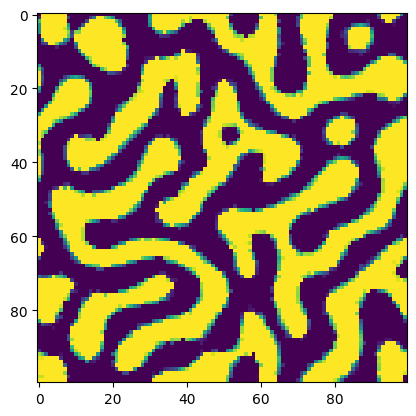

In [24]:
plt.imshow(y_pred[-1,:].reshape(100, 100).to("cpu"))

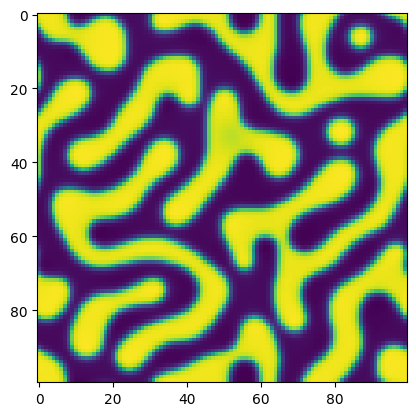

In [27]:
plt.imshow(y1_test[-1,:].reshape(100, 100))